In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import random
import zipfile
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

random.seed(1)# setting random seed
main_data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')

2023-05-08 17:05:40.630735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# main_data['patientID'].value_counts()

In [3]:
cancerTypes = ['epithelial', 'inflammatory', 'fibroblast', 'others']

one_hot = pd.get_dummies(main_data['cellTypeName'])
main_data = main_data.drop('cellTypeName',axis = 1)
main_data = main_data.join(one_hot)
main_data

# https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

,InstanceID,patientID,ImageName,cellType,isCancerous,epithelial,fibroblast,inflammatory,others
0,22405,1,22405.png,0,0,0,1,0,0
1,22406,1,22406.png,0,0,0,1,0,0
2,22407,1,22407.png,0,0,0,1,0,0
3,22408,1,22408.png,0,0,0,1,0,0
4,22409,1,22409.png,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
9891,1625,60,1625.png,2,1,1,0,0,0
9892,1626,60,1626.png,2,1,1,0,0,0
9893,1627,60,1627.png,2,1,1,0,0,0
9894,1628,60,1628.png,2,1,1,0,0,0


In [4]:
main_data.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellType        0
isCancerous     0
epithelial      0
fibroblast      0
inflammatory    0
others          0
dtype: int64

In [5]:
from sklearn.model_selection import GroupShuffleSplit 

splitter = GroupShuffleSplit(n_splits=5, random_state=42)
split = splitter.split(main_data, groups=main_data['patientID'])
splitter.get_n_splits()

5

In [6]:
# X = main_data.drop(columns=["isCancerous"])
# y = main_data["isCancerous"]


# gs_1 = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
# train_test_ix, val_ix = next(gs_1.split(X, y, groups=main_data["patientID"]))
# X_train_test = X.loc[train_test_ix]
# X_val = X.loc[val_ix]
# y_train_test = y.loc[train_test_ix]
# y_val = y.loc[val_ix]

# X_train_test = X_train_test.reset_index(drop=True)
# y_train_test = y_train_test.reset_index(drop=True)
# gs_2 = GroupShuffleSplit(n_splits=1, train_size=.75, random_state=42)
# train_ix, test_ix = next(gs_2.split(X_train_test, y_train_test, groups=X_train_test["patientID"]))
# X_train = X_train_test.loc[train_ix]
# X_test = X_train_test.loc[test_ix]
# y_train = y.loc[train_ix]
# y_test = y.loc[test_ix]

# # https://stackoverflow.com/questions/68152473/python-split-to-train-test-val-using-groupshufflesplit

In [7]:
gs_1 = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
train_test_ix, val_ix = next(gs_1.split(main_data, groups=main_data["patientID"]))
train_test = main_data.loc[train_test_ix]
val = main_data.loc[val_ix]

train_test = train_test.reset_index(drop=True)
gs_2 = GroupShuffleSplit(n_splits=1, train_size=.75, random_state=42)
train_ix, test_ix = next(gs_2.split(train_test, groups=train_test["patientID"]))
train = train_test.loc[train_ix]
test = train_test.loc[test_ix]

# https://stackoverflow.com/questions/68152473/python-split-to-train-test-val-using-groupshufflesplit

NameError: name 'X_train' is not defined

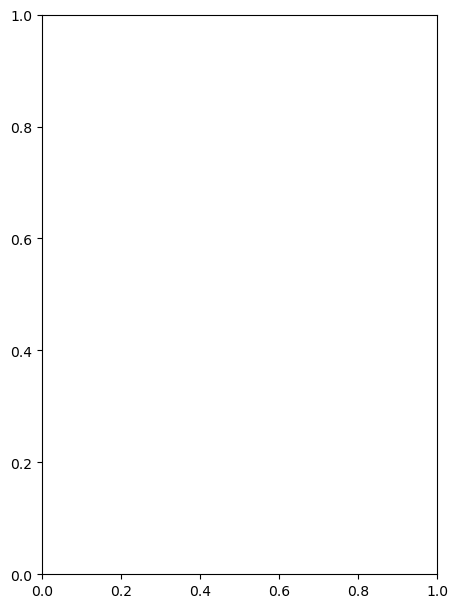

In [8]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.tight_layout(pad=4.0)
plt.hist(x=X_train['patientID'], alpha=0.3, color='r', bins=60,range=(0,60))
plt.hist(x=X_val['patientID'], alpha=0.3, color='b', bins=60, range=(0,60))
plt.hist(x=X_test['patientID'], alpha=0.3, color='g', bins=60, range=(0,60))
plt.xticks(rotation=60)

In [32]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 1
BATCH_SIZE = 27

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    # tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation="sigmoid")
])

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 2187)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 2188      
                                                                 
Total params: 2,188
Trainable params: 2,188
Non-trainable params: 0
_________________________________________________________________


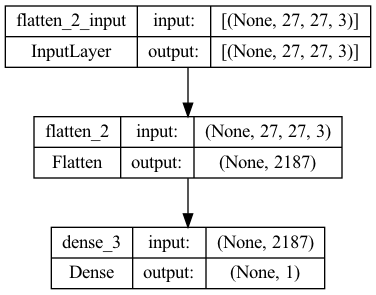

In [35]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [36]:
# from keras.optimizers import SGD
# opt = SGD(learning_rate=0.01)
model.compile(optimizer = 'Adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [37]:
# X_train['isCancerous'] = X_train['isCancerous'].astype('str')
# X_val['isCancerous'] = X_val['isCancerous'].astype('str')

In [38]:
train['isCancerous'] = train['isCancerous'].astype('str')
val['isCancerous'] = val['isCancerous'].astype('str')

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

train_generator = train_gen.flow_from_dataframe(
        dataframe=train,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=BATCH_SIZE,
        class_mode='binary')

validation_generator = val_gen.flow_from_dataframe(
        dataframe=val,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 5671 validated image filenames belonging to 2 classes.
Found 1839 validated image filenames belonging to 2 classes.


In [40]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=50)

Epoch 1/50


/Users/williamfurler/opt/anaconda3/lib/python3.9/site-packages/keras/backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


211/211 [==============================] - 3s 11ms/step - loss: 0.5419 - binary_accuracy: 0.7311 - val_loss: 0.4853 - val_binary_accuracy: 0.7803
Epoch 2/50
211/211 [==============================] - 1s 6ms/step - loss: 0.4250 - binary_accuracy: 0.8168 - val_loss: 0.4935 - val_binary_accuracy: 0.7439
Epoch 3/50
211/211 [==============================] - 1s 6ms/step - loss: 0.3583 - binary_accuracy: 0.8603 - val_loss: 0.4049 - val_binary_accuracy: 0.8254
Epoch 4/50
211/211 [==============================] - 1s 6ms/step - loss: 0.3444 - binary_accuracy: 0.8572 - val_loss: 0.4249 - val_binary_accuracy: 0.8086
Epoch 5/50
211/211 [==============================] - 1s 7ms/step - loss: 0.3466 - binary_accuracy: 0.8519 - val_loss: 0.3739 - val_binary_accuracy: 0.8396
Epoch 6/50
211/211 [==============================] - 2s 8ms/step - loss: 0.3178 - binary_accuracy: 0.8723 - val_loss: 0.3591 - val_binary_accuracy: 0.8461
Epoch 7/50
211/211 [==============================] - 1s 6ms/step - loss: 

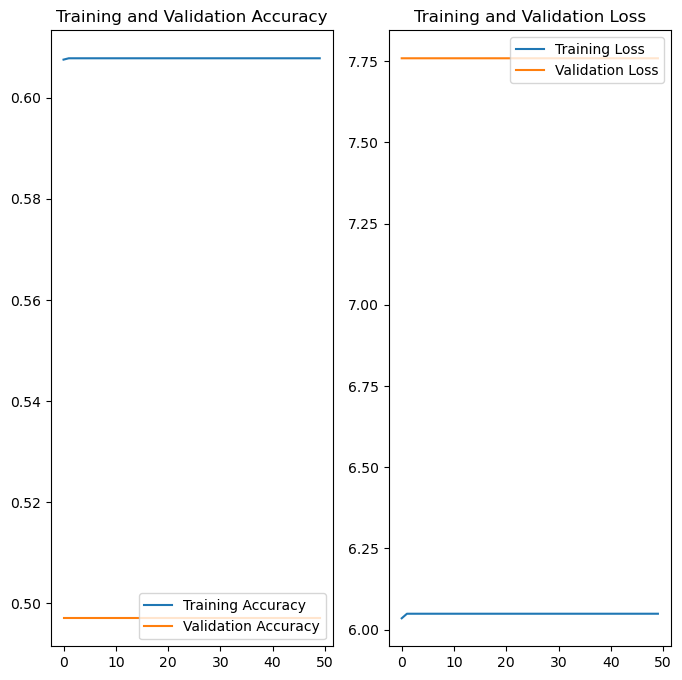

In [18]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()